In [17]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.neighbors import NearestNeighbors

In [18]:
# Load data
data = pd.read_csv('/content/genres_v2 (1).csv')

<ipython-input-18-44d3248701e0>:2: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/content/genres_v2 (1).csv')


In [31]:
# Drop unnecessary columns
data_cleaned = data.drop(columns=['Unnamed: 0', 'title'])

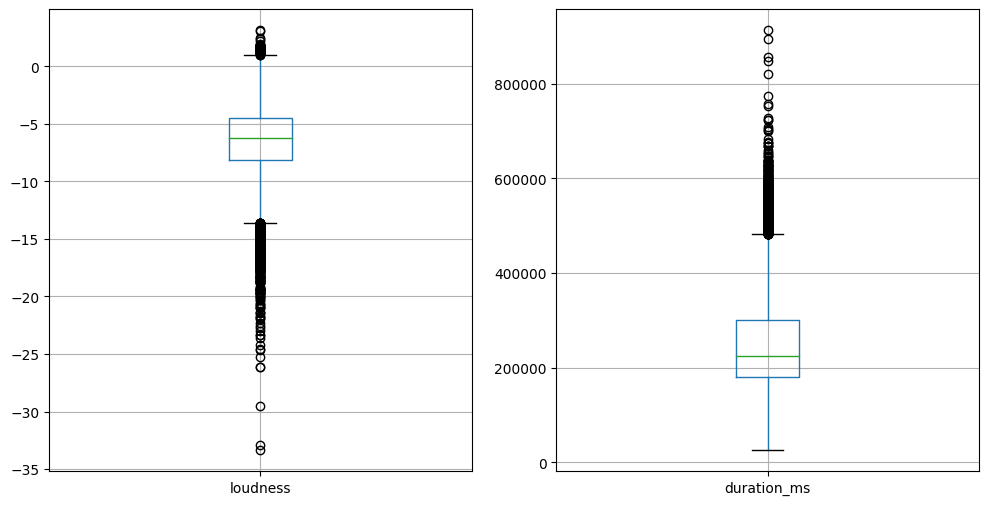

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
data_cleaned.boxplot(column=['loudness'], ax=ax[0])
data_cleaned.boxplot(column=['duration_ms'], ax=ax[1])
plt.show()

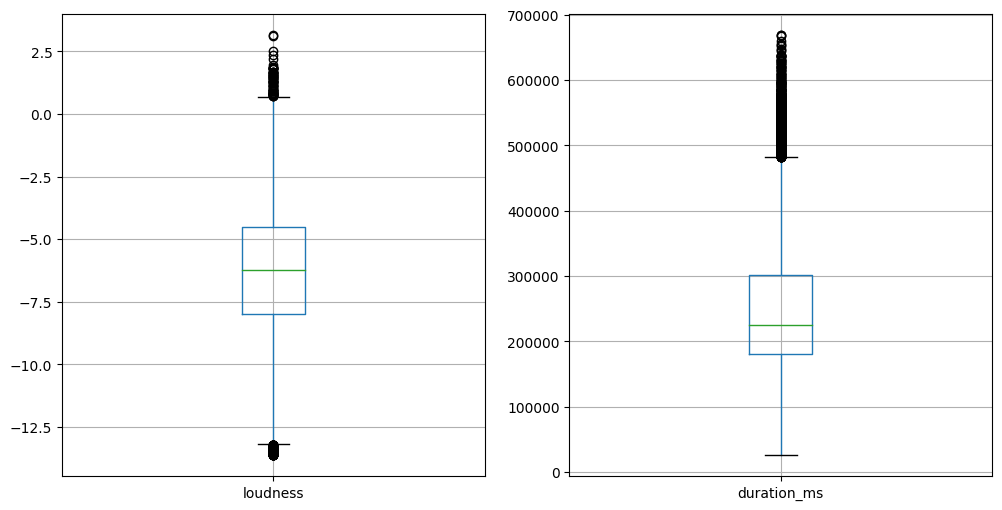

In [21]:
# Calculate medians
loudness_median = data_cleaned['loudness'].median()
duration_median = data_cleaned['duration_ms'].median()

# Replace outliers in 'loudness' (using IQR method to find outliers)
Q1_loudness = data_cleaned['loudness'].quantile(0.25)
Q3_loudness = data_cleaned['loudness'].quantile(0.75)
IQR_loudness = Q3_loudness - Q1_loudness
lower_bound_loudness = Q1_loudness - 1.5 * IQR_loudness
data_cleaned.loc[data_cleaned['loudness'] < lower_bound_loudness, 'loudness'] = loudness_median

# Replace outliers in 'duration_ms' (using a threshold, here 3 times the median)
upper_bound_duration = 3 * duration_median
data_cleaned.loc[data_cleaned['duration_ms'] > upper_bound_duration, 'duration_ms'] = duration_median

# Re-check the data with boxplots to see changes
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
data_cleaned.boxplot(column=['loudness'], ax=ax[0])
data_cleaned.boxplot(column=['duration_ms'], ax=ax[1])
plt.show()

In [22]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)

# Chia tập huấn luyện để tạo tập xác thực
train_set, val_set = train_test_split(train_set, test_size=0.25, random_state=42)

total_train = train_set.shape[0]
total_test = test_set.shape[0]
total_val = val_set.shape[0]
total_train, total_test, total_val

(25383, 8461, 8461)

In [23]:
# Chọn các thuộc tính âm nhạc để dùng làm đặc trưng đầu vào
features = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
            'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

# Tạo các tập dữ liệu đặc trưng (features) và nhãn (label)
X_train = train_set[features]
y_train = train_set['genre']
X_val = val_set[features]
y_val = val_set['genre']
X_test = test_set[features]
y_test = test_set['genre']

In [24]:
# Sampling a subset of data to reduce memory usage
data_subset = data_cleaned.sample(n=15000, random_state=42)
print(data_subset)
data_subset = data_subset.drop_duplicates(subset='id', keep='first')

       danceability  energy  key  loudness  mode  speechiness  acousticness  \
7625          0.859   0.792    2    -4.007     1       0.1410      0.065000   
10059         0.829   0.619    1    -7.258     1       0.1980      0.290000   
8322          0.461   0.834    3    -3.387     0       0.1420      0.261000   
22036         0.691   0.984    1    -4.828     1       0.0610      0.000924   
12324         0.685   0.798    6    -4.683     0       0.0342      0.013100   
...             ...     ...  ...       ...   ...          ...           ...   
40902         0.603   0.808    1    -4.092     1       0.0424      0.002880   
26559         0.796   0.554    6   -10.021     0       0.0476      0.000898   
31930         0.699   0.738    7    -8.929     1       0.0479      0.005850   
10981         0.461   0.547    8    -8.806     1       0.0721      0.137000   
10809         0.815   0.822    1    -4.457     1       0.2970      0.024400   

       instrumentalness  liveness  valence    tempo

In [25]:
# Normalizing feature data
scaler = StandardScaler()
feature_data = scaler.fit_transform(data_subset[features])
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
print(scaler)
print(X_train)
print(X_val)
print(X_test)

StandardScaler()
[[ 1.17507297 -0.97714682  1.25927147 ... -0.62032444 -0.59002323
  -0.31449153]
 [ 1.42373773 -0.72046062  0.44055417 ... -0.52387165  1.9726353
  -0.7755068 ]
 [ 0.4737108  -2.16773389  0.16764841 ... -0.72245093  1.83121769
   0.52475931]
 ...
 [ 0.62673528 -0.62761668 -0.10525735 ... -0.66287715 -0.00721125
   0.9449931 ]
 [-0.64209263  1.24564646 -0.92397465 ...  0.63923555 -0.46146176
   0.31783109]
 [ 1.94657134 -0.55115696  0.16764841 ... -0.51819796  1.82264693
  -0.98390349]]
[[ 1.37272957  0.18067179 -0.10525735 ... -0.61465075  1.27840339
   0.52845146]
 [ 0.42270265 -1.97658459  0.44055417 ... -0.58628228 -0.28576109
  -1.15302913]
 [ 0.09114963  0.13151911 -1.19688041 ... -0.28557652  0.06992563
  -1.15865126]
 ...
 [ 1.24520918 -0.42008315 -1.46978618 ... -0.67025295  0.73415986
  -0.98407131]
 [-0.48906816  0.11513489 -1.19688041 ...  0.98533086 -0.24719265
  -0.09720012]
 [ 0.09114963  0.81419518 -0.10525735 ... -0.58060859 -0.85571692
   0.13892965]]


In [26]:
# Calculating cosine similarity matrix
similarity_matrix = cosine_similarity(feature_data)
print(similarity_matrix)

[[ 1.          0.6338275  -0.15320053 ... -0.40891219  0.1169255
   0.82840455]
 [ 0.6338275   1.         -0.18032913 ... -0.23831107  0.46994306
   0.52589587]
 [-0.15320053 -0.18032913  1.         ... -0.74711332 -0.29038191
   0.03407918]
 ...
 [-0.40891219 -0.23831107 -0.74711332 ...  1.          0.07228082
  -0.52342272]
 [ 0.1169255   0.46994306 -0.29038191 ...  0.07228082  1.
  -0.18494464]
 [ 0.82840455  0.52589587  0.03407918 ... -0.52342272 -0.18494464
   1.        ]]


In [27]:
# Creating a DataFrame for the similarity matrix
similarity_df = pd.DataFrame(cosine_similarity(feature_data), index=data_subset['id'], columns=data_subset['id'])

In [28]:
def clean_song_name(song_name):
    """Clean and normalize the input song name."""
    # Ensure the song name is a string
    if song_name is None:
        return ""  # Return an empty string or some placeholder text for None values
    song_name = str(song_name).strip()  # Convert to string and strip whitespace
    if not song_name:
        return ""  # Return an empty string if song_name is effectively empty after stripping
    # Convert to lower case before normalization
    song_name = song_name.lower()
    # Normalize space around punctuation marks and ensure exactly one space follows any punctuation
    song_name = re.sub(r'\s*([,;.!?])\s*', r'\1 ', song_name).strip()
    # Ensure single spaces between words
    song_name = ' '.join(song_name.split())
    return song_name


def get_similar_songs_by_name(song_name, similarity_df, data, top_n=7):
    song_name = clean_song_name(song_name)
    if 'normalized_song_name' not in data.columns:
        data['normalized_song_name'] = data['song_name'].apply(clean_song_name)

    song_data = data[data['normalized_song_name'] == song_name]
    if song_data.empty:
        return f"Song name '{song_name}' not found in the data."

    song_id = song_data.iloc[0]['id']
    if song_id not in similarity_df.index:
        return f"Song ID {song_id} not found in the similarity data."

    sim_scores = similarity_df.loc[song_id, :]  # Make sure this is a Series
    sim_scores_sorted = sim_scores.sort_values(ascending=False)  # This should now work without error
    top_similar_ids = sim_scores_sorted.iloc[1:top_n+1].index
    top_similar_songs = data[data['id'].isin(top_similar_ids)]

    return top_similar_songs[['song_name', 'genre']]


In [29]:
# Example of use
user_input_song_name = input("Enter a song name to find similar songs: ")
similar_songs = get_similar_songs_by_name(user_input_song_name, similarity_df, data_subset)
print(similar_songs)

Enter a song name to find similar songs: Venom
                            song_name            genre
5001                      Keep it 100  Underground Rap
4679                         RED Rust  Underground Rap
911                         melatonin        Dark Trap
17252  Alive (with Offset & 2 Chainz)              RnB
966                           Kic Bac        Dark Trap
9687                         Meet God  Underground Rap
5191              Love Never Blossoms  Underground Rap


In [30]:
def evaluate_model(similarity_df, data, test_set, top_n=7):
    """Evaluate the collaborative filtering model."""
    total_precision = 0
    total_recall = 0
    count = 0

    for index, row in test_set.iterrows():
        song_name = row['song_name']
        true_genre = row['genre']
        similar_songs = get_similar_songs_by_name(song_name, similarity_df, data, top_n)

        if isinstance(similar_songs, str):
            # Song not found, skip this example
            continue

        true_positive = (similar_songs['genre'] == true_genre).sum()
        precision = true_positive / len(similar_songs) if len(similar_songs) > 0 else 0
        recall = true_positive / top_n

        total_precision += precision
        total_recall += recall
        count += 1

    avg_precision = total_precision / count if count != 0 else 0
    avg_recall = total_recall / count if count != 0 else 0

    return avg_precision, avg_recall
avg_precision, avg_recall = evaluate_model(similarity_df, data_subset, test_set)
print(f"Average Precision: {avg_precision:.2f}")
print(f"Average Recall: {avg_recall:.2f}")


Average Precision: 0.20
Average Recall: 0.20


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.neighbors import NearestNeighbors
import re

# Load data
data = pd.read_csv('/content/genres_v2.csv')

# Drop unnecessary columns and handle missing values
data_cleaned = data.drop(columns=['Unnamed: 0', 'title'])
data_cleaned = data_cleaned.dropna()

# Normalize feature data
features = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
            'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

scaler = StandardScaler()
feature_data = scaler.fit_transform(data_cleaned[features])

# Match the indices of feature_data with data_cleaned
data_cleaned = data_cleaned.reset_index(drop=True)

# Train KNN model
knn = NearestNeighbors(n_neighbors=5, algorithm='auto', metric='cosine')
knn.fit(feature_data)

# Function to get similar songs using KNN
def get_knn_similar_songs(song_index, knn_model, data, k=5):
    distances, indices = knn_model.kneighbors([feature_data[song_index]], n_neighbors=k+1)
    similar_song_indices = indices[0][1:]  # Skip the first index as it is the item itself
    similar_songs = data.iloc[similar_song_indices]
    return similar_songs

# Example of use: Finding similar songs for a given song index
song_index = 0  # Index of the song you want to find similar songs for
similar_songs = get_knn_similar_songs(song_index, knn, data_cleaned)
print(similar_songs[['song_name', 'genre', 'id']])

# Evaluation function
def evaluate_knn_model(knn_model, test_data, feature_data, data, k=5):
    total_precision = 0
    total_recall = 0
    count = 0
    for index, row in test_data.iterrows():
        try:
            song_index = data.index[data['id'] == row['id']].tolist()[0]
            if song_index >= len(feature_data):
                continue
            distances, indices = knn_model.kneighbors([feature_data[song_index]], n_neighbors=k+1)
            similar_song_indices = indices[0][1:]
            similar_songs = data.iloc[similar_song_indices]['genre']
            true_positive = sum(similar_songs == row['genre'])
            precision = true_positive / len(similar_songs)
            recall = true_positive / 1
            total_precision += precision
            total_recall += recall
            count += 1
        except IndexError:
            print(f"An index error occurred with song_index: {song_index}")
    avg_precision = total_precision / count if count != 0 else 0
    avg_recall = total_recall / count if count != 0 else 0
    return avg_precision, avg_recall

# Splitting data into train and test sets
train_set, test_set = train_test_split(data_cleaned, test_size=0.2, random_state=42)
X_train, X_test = train_test_split(feature_data, test_size=0.2, random_state=42)

# Evaluate KNN model
avg_precision, avg_recall = evaluate_knn_model(knn, test_set, feature_data, data_cleaned, k=5)
print(f"Average Precision: {avg_precision:.2f}")
print(f"Average Recall: {avg_recall:.2f}")

# Function to clean and normalize song name
def clean_song_name(song_name):
    if song_name is None:
        return ""
    song_name = str(song_name).strip().lower()
    song_name = re.sub(r'\s*([.,;!?])\s*', r'\1 ', song_name)
    song_name = ' '.join(song_name.split())
    return song_name

# Function to find similar songs by name using the similarity dataframe
def get_similar_songs_by_name(song_name, similarity_df, data, top_n=7):
    song_name = clean_song_name(song_name)
    if 'normalized_song_name' not in data.columns:
        data['normalized_song_name'] = data['song_name'].apply(clean_song_name)

    song_data = data[data['normalized_song_name'] == song_name]
    if song_data.empty:
        return f"Song name '{song_name}' not found in the data."

    song_id = song_data.iloc[0]['id']
    if song_id not in similarity_df.index:
        return f"Song ID {song_id} not found in the similarity data."

    sim_scores = similarity_df.loc[song_id]
    sim_scores_sorted = sim_scores.sort_values(ascending=False)
    top_similar_ids = sim_scores_sorted.iloc[1:top_n+1].index
    top_similar_songs = data[data['id'].isin(top_similar_ids)]

    return top_similar_songs[['song_name', 'genre']]

# Creating a DataFrame for the similarity matrix
similarity_matrix = cosine_similarity(feature_data)
similarity_df = pd.DataFrame(similarity_matrix, index=data_cleaned['id'], columns=data_cleaned['id'])

# Example of use: Finding similar songs by name
user_input_song_name = input("Enter a song name to find similar songs: ")
similar_songs = get_similar_songs_by_name(user_input_song_name, similarity_df, data_cleaned)
print(similar_songs)


<ipython-input-25-71d0de87e614>:10: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/content/genres_v2.csv')


                 song_name            genre                      id
20037  Mercury: Retrograde           Hiphop  2Vc6NJ9PW9gD9q343XFRKx
0      Mercury: Retrograde        Dark Trap  2Vc6NJ9PW9gD9q343XFRKx
15615  Mercury: Retrograde              Rap  2Vc6NJ9PW9gD9q343XFRKx
4624   Mercury: Retrograde  Underground Rap  2Vc6NJ9PW9gD9q343XFRKx
8941          Run Boy Run!  Underground Rap  1e48ZOCRRhgY0n5aMbxXcS
Average Precision: 0.36
Average Recall: 1.80
Enter a song name to find similar songs: killer
                           song_name            genre
88                            Hexada        Dark Trap
645                   HOLD UR TONGUE        Dark Trap
5322   HOLD UR TONGUE (PROD. CXRPSE)  Underground Rap
5881                          Hexada  Underground Rap
7703                     Go To Sleep  Underground Rap
8198                            Bars  Underground Rap
8940                          KILLER  Underground Rap
10696                         Hexada       Trap Metal
11853        